# Overview
Now we've gotten a feel for what raw EEG / ECoG data look like, and we've successfully sliced up that data according to events that we detected in the neural signals (eyeblinks). However, what we're really interested in is to determine how the neural activity corresponds to events **in the world**. In this class we will begin exploring how to conduct experiments in order to ask questions about the function of the brain. We'll discuss how to use event timing information in order to extract patterns of activity that correspond to that event. We'll also discuss how to compare these patterns between event types.

## Goals for today
* Understanding how an experiment relates to the neural data / how to use metadata in analyses.
* Create an `Epochs` representation of data. That is, create a window around times of interest and analyze patterns of activity in that window.
* Infer differences in activity between events, and use statistics / resampling methods to determine if there is a "significant" difference between conditions.

---


# Experiments
Now that we know how to slice up our data, we can begin running experiments! Thus far, we've focused on defining "events" as physiological signals that we can detect automatically (e.g., eyeblinks). However, in neuroscience it is most common to keep information about *when* we presented certain things to the brain, and use this to ask *what* happened as a result.

For this, we should talk a bit about experiments. See the associated powerpoints for a quick primer on experimental design. In addition, there is a `psychopy` experiment file in this notebook. If you have `psychopy` then you can run this file and see an example of one experiment. You can download Psychopy [here](http://www.psychopy.org/)

**powerpoint on experimental design**

In [ ]:
%matplotlib notebook
import mne
import datascience as ds
import numpy as np
import matplotlib.pyplot as plt
import neurods as nds

In [ ]:
# Load the data
path_data_root = nds.io.data_list['eeg'] + 'mne_sample/'
path_raw_data = path_data_root + 'mne_sample-raw.fif'
raw = mne.io.Raw(path_raw_data)
# Load the events
path_events = path_data_root + 'mne_sample-events.csv'
ev_df = ds.Table.read_table(path_events)
# Load the event mapping
path_event_info = path_data_root + 'mne_sample-event_info.csv'
ev_info = ds.Table.read_table(path_event_info)

Opening raw data file /home/shared/cogneuro-connector/data/eeg/mne_sample/mne_sample-raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated


In [ ]:
# Let's look at the events
print(ev_df.shape)
ev_df

previous_value | event_type | index
[320]          | [320]      | [320]


previous_value,event_type,index
0,2,27977
0,3,28345
0,1,28771
0,4,29219
0,2,29652
0,3,30025
0,1,30450
0,4,30839
0,2,31240
0,3,31665


In [ ]:
# Event id mappings
ev_info

name,id,description
LA,1,Response to left-ear auditory stimulus
RA,2,Response to right-ear auditory stimulus
LV,3,Response to left visual field stimulus
RV,4,Response to right visual field stimulus
smiley,5,Response to the smiley face
button,32,Response triggered by the button press


In [ ]:
# Column labels
print(ev_df.labels)

('previous_value', 'event_type', 'index')


In [ ]:
# First, we'll load in the event timings
# We need to reshape them to be the format that MNE wants
events = ev_df.select(['index', 'previous_value', 'event_type']).values

In [ ]:
print(ev_df.values[:5])
print('\n---\n')
# Note that it's the same data, but with columns rearranged
print(events[:5])

[[    0     2 27977]
 [    0     3 28345]
 [    0     1 28771]
 [    0     4 29219]
 [    0     2 29652]]

---

[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


In [ ]:
# We can also use our event info to create a dictionary MNE can use
ev_id = dict()
for i_name, i_id, i_desc in ev_info.rows:
    ev_id[i_name] = int(i_id)

In [ ]:
print(ev_id)

{'RV': 4, 'smiley': 5, 'LA': 1, 'RA': 2, 'button': 32, 'LV': 3}


In [ ]:
# This lets us create an Epochs object, which we can use to view the data
epochs = mne.Epochs(raw, events, event_id=ev_id)

320 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated


Note that if we wanted to operate on the data directly, we would not be able to access `_data` yet because `preload=False` when we constructed the epochs. In this case, to get the data we can use the `get_data` method, which is a way of loading the data in case `preload` is `False`. It will simply return an array of your data.

In [ ]:
epochs

<Epochs  |  n_events : 320 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'LA': 72, 'LV': 73, 'RA': 73, 'RV': 71, 'button': 16, 'smiley': 15>

In [ ]:
print epochs.get_data().shape
n_timepoints = epochs.get_data().shape[-1]

Loading data for 320 events and 421 original time points ...
0 bad epochs dropped


(320, 59, 421)

In [ ]:
### TEACHER INFO


600.614990234375
600.614990234375


Loading data for 320 events and 421 original time points ...


<IPython.core.display.Javascript object>


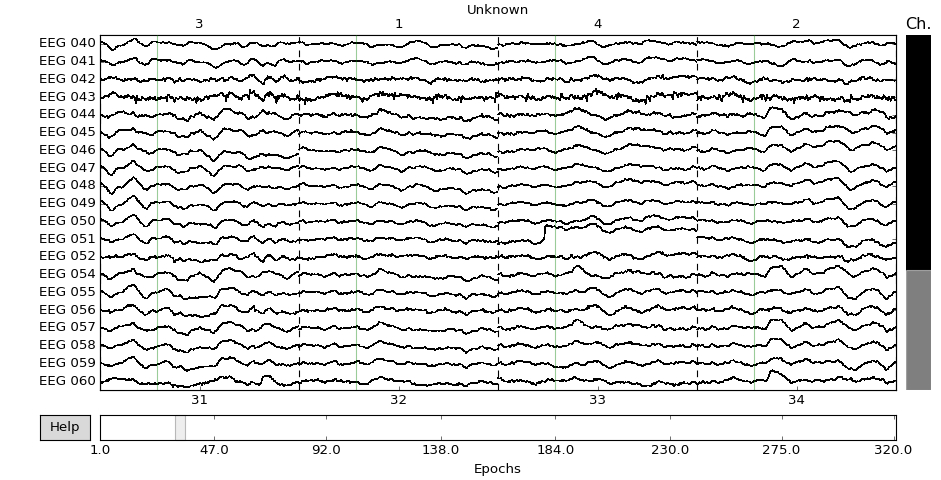

Loading data for 4 events and 421 original time points ...


In [ ]:
# We can take a look at the raw data and see what happens when an event starts:
_ = epochs.plot(scalings='auto', n_epochs=4)

> * Can you tell any differences between the event types?
> * How is this different / similar to the eyeblink events?

## Event-Related Potentials (ERPs)
Signals such as EEG are often too noisy to see something going on on a single trial level. There is too much variability from trial to trial, and this variability is often a larger amplitude than the signal we care about.

However, this variability is also semi-random, whereas the brain response to an event is consistent. This means that we should be able to "average out" the noise, and retain the signal.

To do this, we generally average across multiple instances of the same event. The noise is random, so tends to cancel itself out, while the signal should remain.

In general, EEG or ECoG will have a similar response to the same stimulus. When we average out all the noise across trials, we are left with these "average" responses. We call them *event-related potentials* (ERPs).

Below we'll calculate some ERPs for a particular event-types and see how they compare with one another. We'll focus on the events where a person pressed a button here, and we'll go through some other event types in the lab.

First, we need to figure out which `event_id` corresponds to a button press.

In [ ]:
# First check what epochs is
epochs

<Epochs  |  n_events : 320 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'LA': 72, 'LV': 73, 'RA': 73, 'RV': 71, 'button': 16, 'smiley': 15>

In [ ]:
# We'll take a look at what happened when the person pressed a button
# First find the event IDs to determine the type we want
epochs.event_id

{'LA': 1, 'LV': 3, 'RA': 2, 'RV': 4, 'button': 32, 'smiley': 5}

Next, we want to pull the subset of epochs that correspond to this event type:

In [ ]:
# Next, we can pull the subset of events corresponding to a button press:
epochs_button = epochs['button']

# Note that we could also just index a subset of events like this:
#epochs[2:3]

Let's plot the raw data to see if there is a particular pattern that emerges for this kind of trial.

Loading data for 16 events and 421 original time points ...


<IPython.core.display.Javascript object>


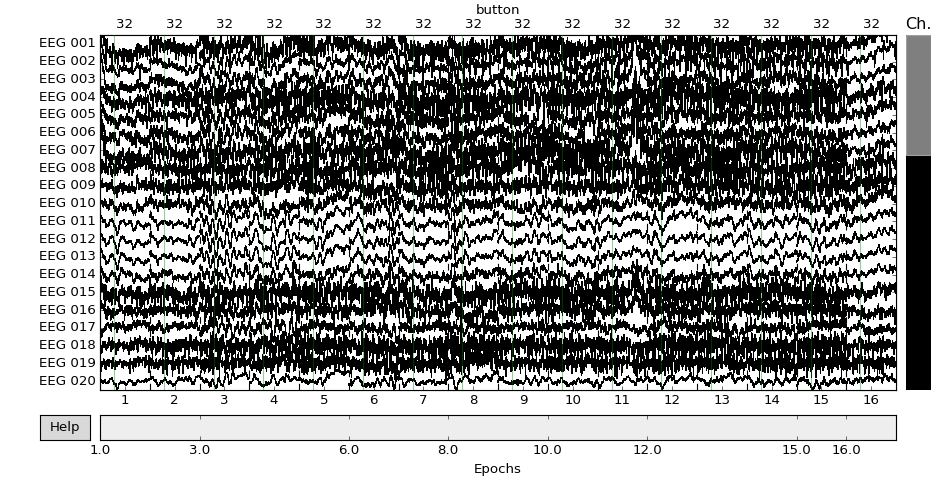

Loading data for 16 events and 421 original time points ...


In [ ]:
# Let's look at the raw data again to see what's there
_ = epochs_button.plot(scalings='auto')

In [ ]:
epoch_data = epochs_button.get_data()
epoch_data.shape # (n_events, n_channels, n_timepoints)

Loading data for 16 events and 421 original time points ...


(16, 59, 421)

We'll average across trials for each electrode now, and see if something clear comes out:

<IPython.core.display.Javascript object>


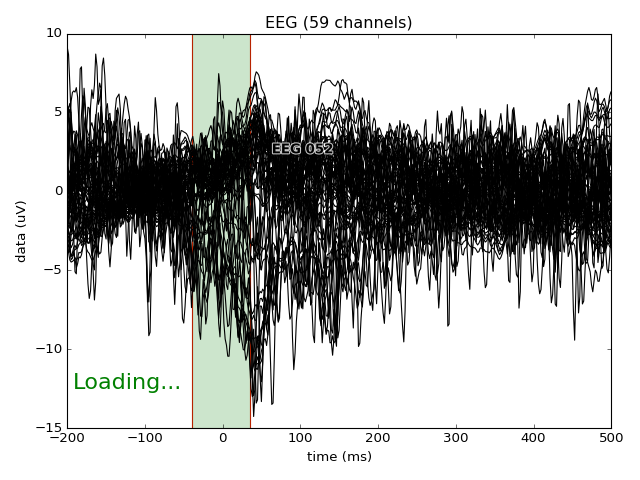

In [ ]:
# We'll average across events/trials by using the MNE `average` method.
evoked = epochs_button.average()
_ = evoked.plot()

> * Does it seem like there is something going on here? Is it more or less noisy than the eyeblinks we looked at before?

Let's investigate further by plotting the topomap at different points in time:

<IPython.core.display.Javascript object>


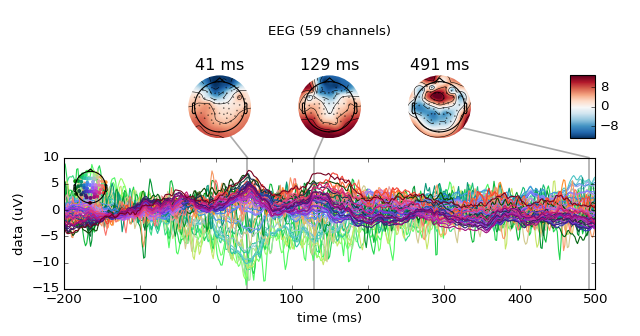

In [ ]:
# We can clean up this figure a little bit by using the `plot_joint` function
_ = evoked.plot_joint()

> * What pattern emerges across the brain for this event type?
> * Why do you think this is?

In [ ]:
### TEACHER INFO


## Baselining with Events
Last week, we talked about using baselining to make sure that each channel was at roughly the same level, this made it easier to compare activity between channels.

However, there's another important use for baselining. Often in neuroscience we care about the brain's response to an event (e.g. the onset of a sound). As such, we really want to know what the response was like *after* the event occurred, relative to the brain activity *before* the event occurred.

Look at the output of the `print` statement below.

In [ ]:
print(epochs_button)

<Epochs  |  n_events : 16 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0), ~3.1 MB, data not loaded>


Note that they include `baseline : (None, 0)`. This means that each epoch has been baselined using all pre-stimulus times (`None` just means "take the earliest possible timepoint for a given window, and `0` is the event onset).

We can re-baseline the data using other timepoints, let's see how this changes the plot for the average activity. 

We can re-baseline data with the `mne.baseline.rescale` function. This takes data as input, as well as a time window for a baseline, and it will subtract the mean within the baseline window *for every channel, for every epoch*.

In [ ]:
mne.Epochs

In [ ]:
# We'll preload the data so it's available to work on
epochs.load_data()

Loading data for 320 events and 421 original time points ...


<Epochs  |  n_events : 320 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'LA': 72, 'LV': 73, 'RA': 73, 'RV': 71, 'button': 16, 'smiley': 15>

Applying baseline correction (mode: mean)


<IPython.core.display.Javascript object>


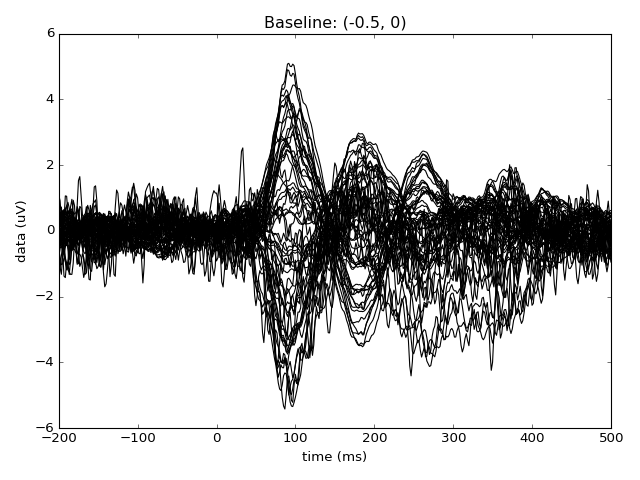

Applying baseline correction (mode: mean)


<IPython.core.display.Javascript object>


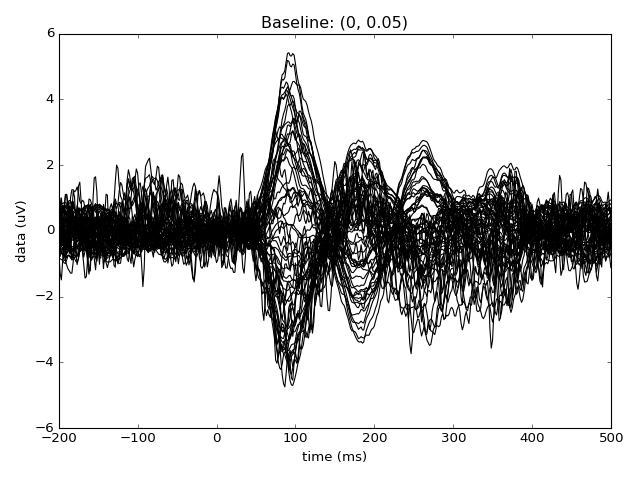

Applying baseline correction (mode: mean)


<IPython.core.display.Javascript object>


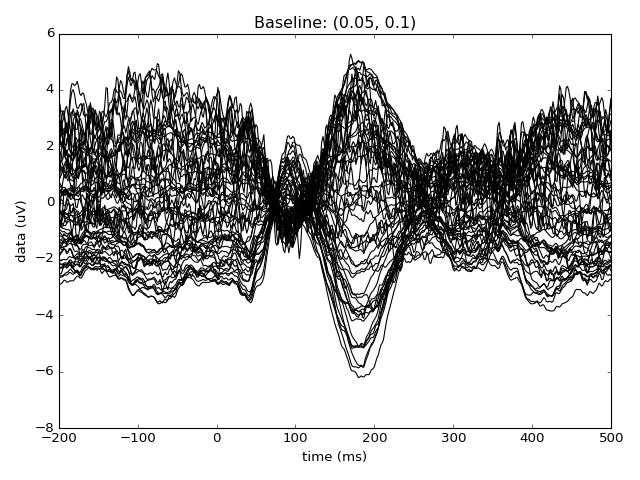

Applying baseline correction (mode: mean)


<IPython.core.display.Javascript object>


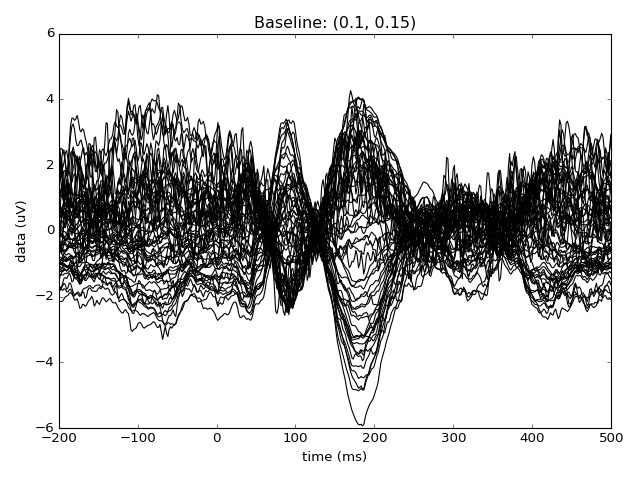

In [ ]:
# We'll try a few baselines and plot the results of each
baselines = [(-.5, 0), (0, .05), (.05, .1), (.1, .15)]
for baseline in baselines:
    # Using `copy=False` modifies the data in-place
    _ = mne.baseline.rescale(epochs._data, epochs.times, baseline, copy=False)
    av = epochs.average()
    fig = av.plot(show=False)
    fig.axes[0].set_title('Baseline: {}'.format(baseline))
    fig.show()

# Global Field Potential

As we've seen, there's a lot of interesting detail in how the activity changes across channels (e.g. looking at topomaps). However, sometimes we just want a single timeseries that describes the general activity across the *entire* collection of channels. This basically removes information about each individual channel, and instead describes at a general level when things are happening.

The simplest way to do this might be to average across all of the electrodes...let's try that below.

In [ ]:
# We'll perform this manually on the epochs data
data = epochs_button.get_data()
print(data.shape)

Loading data for 16 events and 421 original time points ...
(16, 59, 421)


In [ ]:
# First, average across each trial:
data_av = np.mean(data, 0)  # same as above: epochs_button.average()

# Then, average across channels
data_global = np.mean(data_av, 0)

In [ ]:
type(data_global)

numpy.ndarray

<IPython.core.display.Javascript object>


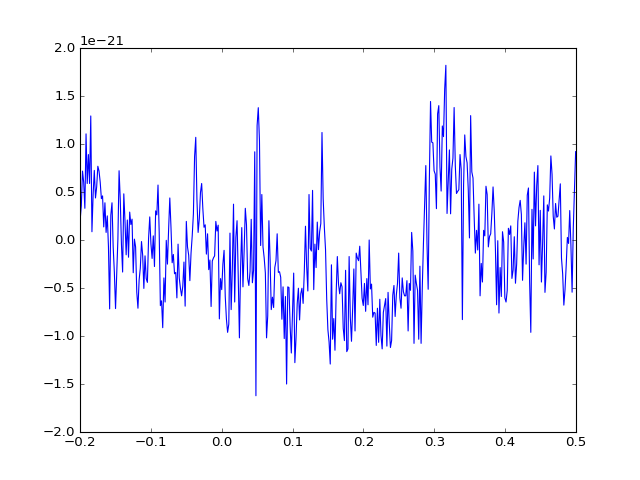

In [ ]:
# We'll plot the general activity level for this subject with matplotlib:
fig, ax = plt.subplots()
ax.plot(epochs.times, data_global)

> * You might notice that the y-axis is really tiny...why is this?
> * Does a clear picture seem to emerge from this plot?

In [ ]:
### TEACHER INFO


Let's try squaring each channel first, and then see what happens.

<IPython.core.display.Javascript object>


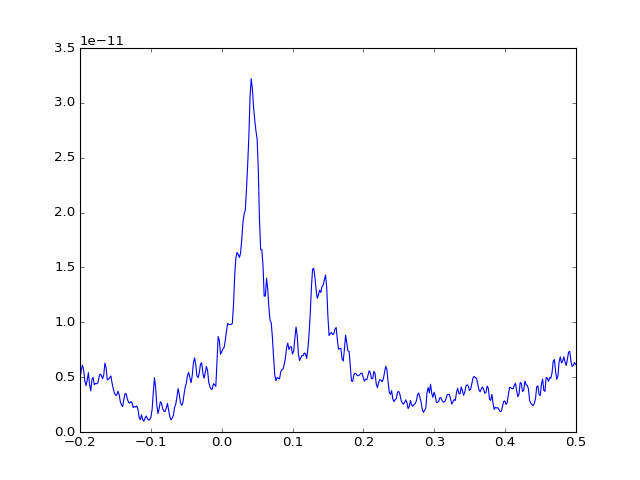

In [ ]:
data_global = np.mean(data_av ** 2, 0)
fig, ax = plt.subplots()
ax.plot(epochs.times, data_global)

Now we can see that there is a clear peak that occurs just after time 0, and maybe another after 100ms.

> * What kind of information do you think we can infer from this?
> * Why would there be two different peaks in the signal?

In [ ]:
### TEACHER INFO


When we square each channel, and then average across channels, we calculate something called the *Global Field Potential*. This is a general description of when there is "stuff going on" across the entire collection of electrodes.

# Calculating / Visualizing variability
In this lecture, we've averaged out the "noise" present from trial to trial by averaging across trials, assuming that whatever remains is the "signal" we really care about. However, it is often important to know more than just the "mean" signal across trials. It's also useful to know how *variable* the signal is across trials.

There are many ways to calculate variability across trials, but the easiest is probably *standard error*. Briefly, this is a way for expressing how *confident* we are in the mean that is calculated across trials. For example, these two signals are sampled from the same univariate “normal” (Gaussian) distribution with mean 0:

<IPython.core.display.Javascript object>


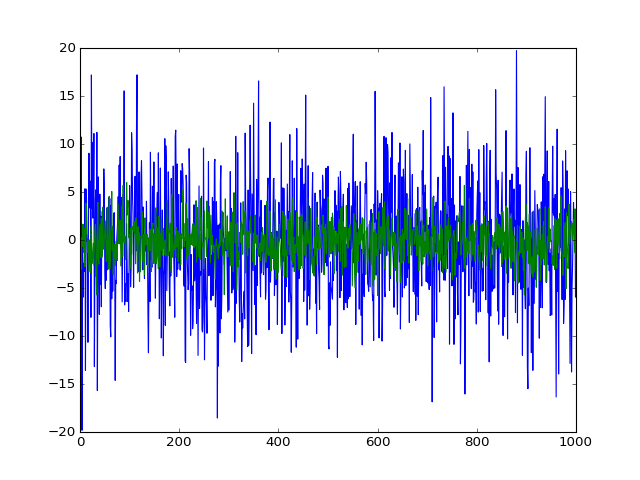

-0.253534176836
-0.103312886111


In [ ]:
sig_a = 6 * np.random.randn(1000)
sig_b = 2 * np.random.randn(1000)
fig, ax = plt.subplots()
ax.plot(sig_a)
ax.plot(sig_b)

print(sig_a.mean())
print(sig_b.mean())

<IPython.core.display.Javascript object>


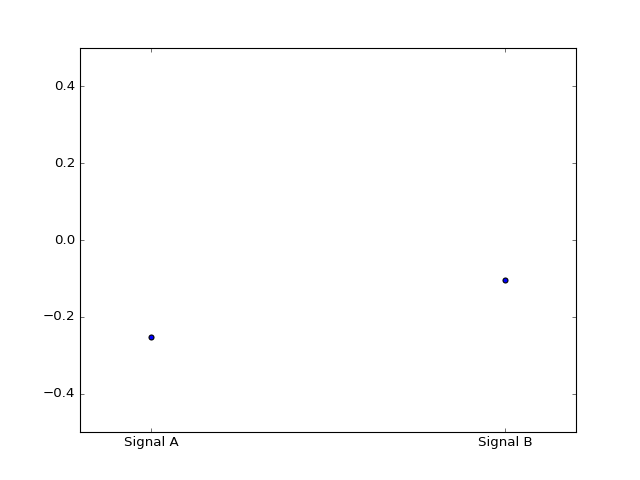

In [ ]:
# Now we can plot the mean of each signal as a scatterplot
fig, ax = plt.subplots()
ax.scatter([0, 1], [sig_a.mean(), sig_b.mean()])
ax.set_ylim([-.5, .5])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Signal A', 'Signal B'])

However, we can tell that *just* calculating the mean for each signal will miss something important about the difference between the two. We need some measure about the *variability* of the mean, which we can also describe as our *uncertainty* of the "true" mean. Let's do this with standard error, which takes the following form:

$$sterr = \frac{\sigma}{\sqrt{N}}$$

That is, we calculate the standard deviation ($\sigma$) of each signal, then divide it by the square root of the number of samples ($N$). This means that the more samples we have, the smaller the standard error will be, and the more confident we are that the sample mean is the "true" mean.

By calculating standard error, our scatterplot above can be a line plot, where the limits of the line express the standard error:

In [ ]:
### TEACHER INFO


In [ ]:
def standard_error(data):
    return np.std(data) / np.sqrt(data.shape[0])

<IPython.core.display.Javascript object>


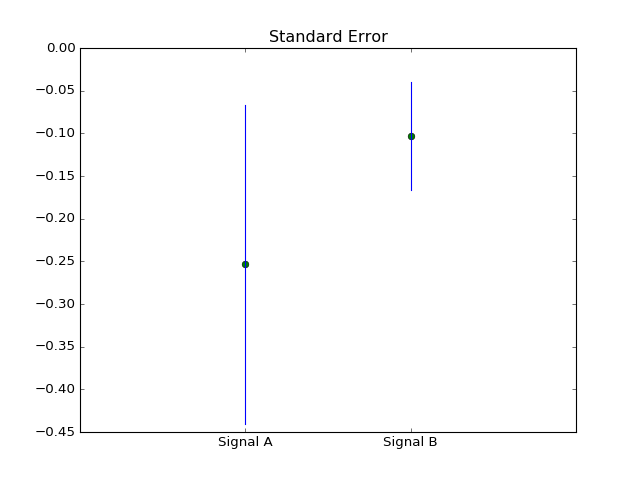

In [ ]:
fig, ax = plt.subplots()
for ii, sig in enumerate([sig_a, sig_b]):
    ax.plot(ii, sig.mean(), 'og')
    ax.plot([ii, ii],
            [sig.mean() - standard_error(sig),
             sig.mean() + standard_error(sig)], 'b')
ax.set_xlim([-1, 2])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Signal A', 'Signal B'])
ax.set_title('Standard Error')

Clearly we have more information about not only the means, but also their variability (Signal B is a much less variable signal, and thus more reliable).

We can express variability in a timeseries as well. For example, rather than just calculating the Global Field Potential of our data, we can calculate the standard error across channels.

We'll use data_av, which is the average activity for each channel (averaging across epochs).

In [ ]:
print(data_av.shape)

(59, 421)


In [ ]:
# Calculate the standard error across channels
data_global_ste = nds.stats.standard_error(data_av ** 2)
print(data_global_ste.shape)

(421,)


Since we still have a timeseries, a useful function is `fill_between`, which lets us fill a range of values in the plot:

<IPython.core.display.Javascript object>


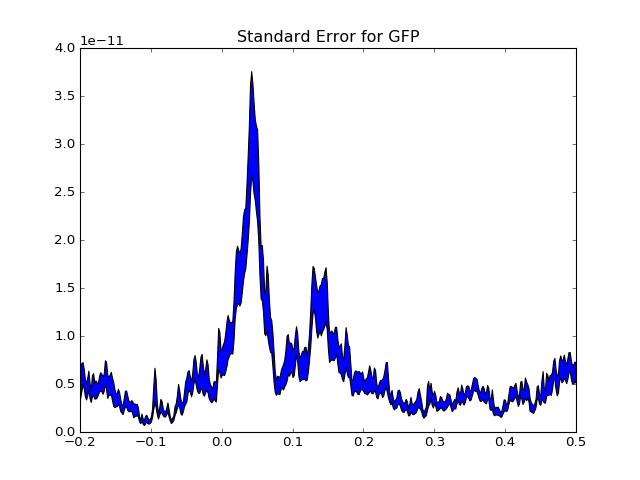

In [ ]:
# Now, we can plot the mean +/- standard error for each channel...
fig, ax = plt.subplots()
ax.fill_between(epochs.times, data_global - data_global_ste,
                data_global + data_global_ste)
ax.set_title('Standard Error for GFP')

> * What do you think it means if the standard error is particularly small with GFP?
> * What does it mean if the standard error is really big?

In [ ]:
### TEACHER INFO


# Lab time!